Libraries

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

Reading and Grayscaling Watermark Image

In [188]:
host_image_size = 512
watermarked_image_size = 32

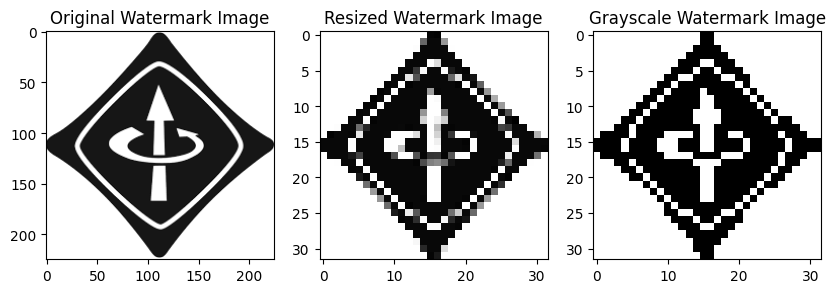

(32, 32)


In [189]:
watermark_image = cv.imread("../img/watermark.png", cv.IMREAD_GRAYSCALE)
resized_watermark_image = cv.resize(watermark_image, (watermarked_image_size, watermarked_image_size))

gray_watermark_image = np.zeros_like(resized_watermark_image)
for i in range(len(resized_watermark_image)):
    for j in range(len(resized_watermark_image[0])):
        if resized_watermark_image[i][j] <= 122: #paint white if value is smaller than the thereshold
            gray_watermark_image[i][j] = 0
        else:
            gray_watermark_image[i][j] = 255 #paint black otherwise

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(watermark_image, cmap="gray")
plt.title("Original Watermark Image")
plt.subplot(1,3,2)
plt.imshow(resized_watermark_image, cmap="gray")
plt.title("Resized Watermark Image")
plt.subplot(1,3,3)
plt.imshow(gray_watermark_image, cmap="gray")
plt.title("Grayscale Watermark Image")
plt.show()

print(gray_watermark_image.shape)

Reading Host Image


In [190]:
host_image = plt.imread("../img/smurf_cat.png")
gray_host_image = np.mean(host_image, axis=2)
gray_host_image = cv.resize(gray_host_image, (host_image_size, host_image_size))

print(gray_host_image.shape)

(512, 512)


Singular Value Decomposition

In [191]:
def SVD(image):
    square_image = np.matmul(image.T, image)

    eigenvalues, eigenvectors = np.linalg.eig(square_image)
    singularvalues = np.sqrt(abs(eigenvalues))
    
    V = []
    VT = []
    U = []
    s = []
    index = 0
    for sv_idx in range(image.shape[0]):
        row = []
        for col_idx in range(image.shape[1]):
            if sv_idx == index and col_idx == index:
                if sv_idx >= len(singularvalues):
                    row.append(0)
                else:
                    row.append(singularvalues[sv_idx])
                    index += 1
            else:
                row.append(0)
        s.append(row)
    s = np.array(s)
   
    V = eigenvectors
    VT = V.T

    for i in range(image.shape[0]):
        U_col = np.array(1)
        if i >= len(eigenvalues):
            U_col = np.zeros_like(image[:, 0]) 
        else:
            if singularvalues[i] == 0:
                U_col = np.zeros_like(image[:, 0]) 
            else: 
                U_col = np.matmul(image, V[:, i]) / singularvalues[i]
        U.append(U_col)
    U = np.array(U)
    U = U.T

    return U, s, VT

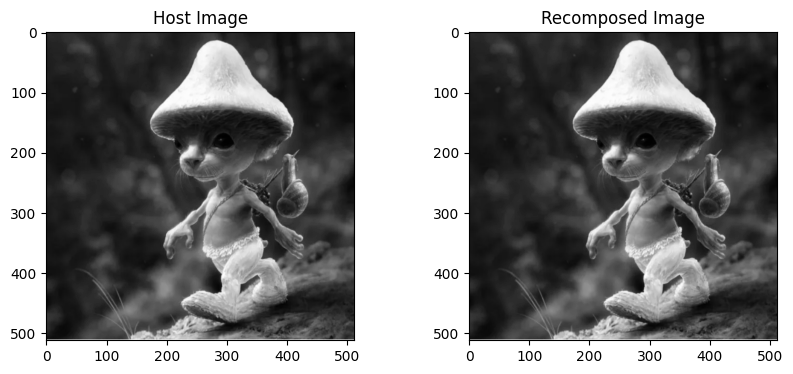

In [192]:
U, s, VT = SVD(gray_host_image)

recomposed_image = np.dot(U, np.dot(s, VT))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Host Image")
plt.imshow(gray_host_image, cmap="gray")
plt.savefig("../output/gray_host_image.png", bbox_inches='tight', pad_inches=0)
plt.subplot(1,2,2)
plt.title("Recomposed Image")
plt.imshow(recomposed_image, cmap="gray")
plt.savefig("../output/recomposed_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

Embedding Watermark

In [193]:
ratio = len(gray_host_image) // len(gray_watermark_image) 
Q = 0.1 # the more we increase, the more watermarked host image will be distorded 

In [194]:
def embed_watermark(host_image, watermark):
    R1 = host_image.shape[0] // watermark.shape[0] # we have (32,32) sized watermark and (512,512) sized host image so we should keep the ratio
    R2 = host_image.shape[1] // watermark.shape[1]

    watermarked_image = np.empty_like(host_image)

    for i in range(0, watermark.shape[0]): #applying the formula given in the paper
        for j in range(0, watermark.shape[1]):
            watermark_bit = watermark[i][j]

            U, s, VT = SVD(host_image[i*R1:(i+1)*R1 , j*R2:(j+1)*R2])
            
            Z = s[0][0] % Q

            if watermark_bit == 0:
                if Z < 3*Q/4:
                    s[0][0] = s[0][0] + Q/4 - Z
                else:
                    s[0][0] = s[0][0] + 5*Q/4 - Z
            elif watermark_bit == 255:
                if Z < Q/4:
                    s[0][0] = s[0][0] - Q/4 + Z
                else:
                    s[0][0] = s[0][0] + 3*Q/4 - Z
            
            watermarked_image[i*R1:(i+1)*R1 , j*R2:(j+1)*R2] = np.dot(U, np.dot(s, VT))
    return watermarked_image

C:\Users\Kemal Tahir\AppData\Local\Temp\ipykernel_17112\2328328289.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  watermarked_image[i*R1:(i+1)*R1 , j*R2:(j+1)*R2] = np.dot(U, np.dot(s, VT))


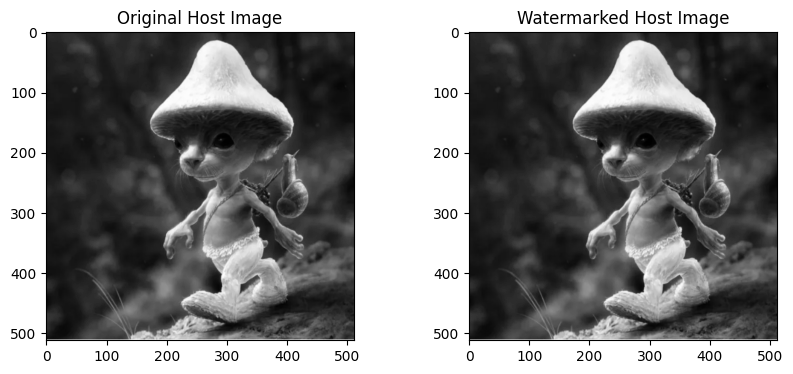

In [195]:
watermarked_host_image = embed_watermark(gray_host_image, gray_watermark_image)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Host Image")
plt.imshow(gray_host_image, cmap="gray")
plt.subplot(1,2,2)
plt.title("Watermarked Host Image")
plt.imshow(watermarked_host_image, cmap="gray")
plt.savefig("../output/watermarked_host_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

Extracting Watermark

In [196]:
def extract_watermark(watermarked_image):
    watermark = list()
    for i in range(0, watermarked_image.shape[0] // ratio):
        row = list()
        for j in range(0, watermarked_image.shape[1] // ratio):
            U, s, VT = SVD(watermarked_image[i*ratio:(i+1)*ratio , j*ratio:(j+1)*ratio])
            
            Z = s[0][0] % Q
            
            if(Z < Q/2): #applying the formula given in the paper
                row.append(0)
            else:
                row.append(255)
        watermark.append(row)
            
    size = len(watermark)
    watermark = np.array(watermark).reshape((size, size))
    
    return watermark

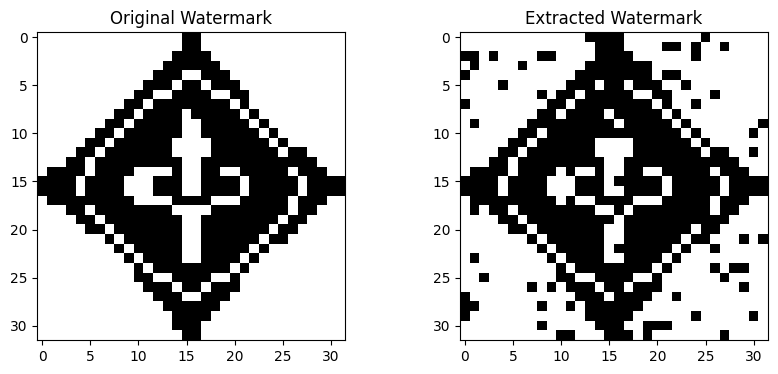

In [197]:
extracted_watermark = extract_watermark(watermarked_host_image)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Watermark")
plt.imshow(gray_watermark_image, cmap="gray")
plt.subplot(1,2,2)
plt.title("Extracted Watermark")
plt.imshow(extracted_watermark, cmap="gray")
plt.show()

PSNR Value

In [198]:
def psnr(host_image, watermarked_image):
    mse = np.mean((host_image - watermarked_image) ** 2)
    
    max_pixel = 255.0
    
    psnr_val = 10 * np.log10((max_pixel ** 2) / mse)
    return int(psnr_val)

psnr_V = psnr(gray_host_image, watermarked_host_image)
print("PSNR value: ", psnr_V)

PSNR value:  104


Extracting Watermark from Tampered Image

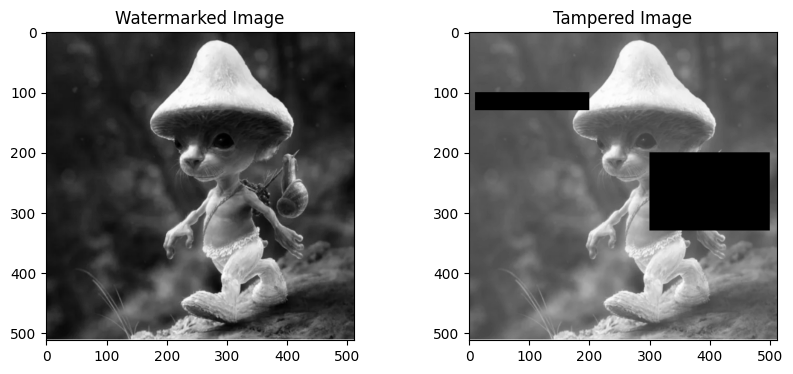

In [199]:
tampered_host_image = np.copy(watermarked_host_image)
tampered_host_image[100:130, 10:200] = 0
tampered_host_image[200:330, 300:500] = 0

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Watermarked Image")
plt.imshow(watermarked_host_image, cmap="gray")
plt.subplot(1,2,2)
plt.title("Tampered Image")
plt.imshow(tampered_host_image, cmap="gray")
plt.show()

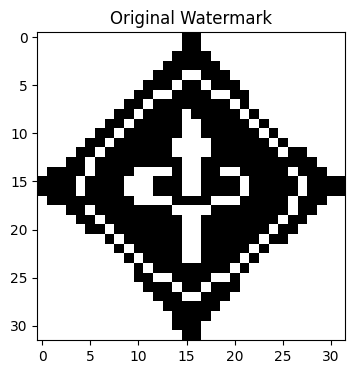

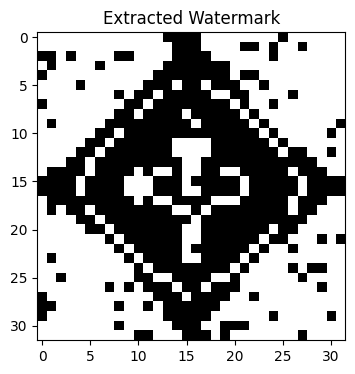

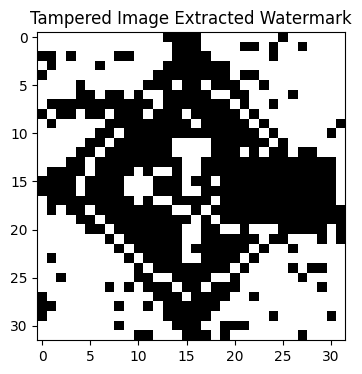

In [200]:
tampered_image_extract_watermark = extract_watermark(tampered_host_image)

plt.figure(figsize=(10,4))
plt.title("Original Watermark")
plt.imshow(gray_watermark_image, cmap="gray")
plt.savefig("../output/gray_watermark_image.png", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,4))
plt.title("Extracted Watermark")
plt.imshow(extracted_watermark, cmap="gray")
plt.savefig("../output/extracted_watermark.png", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,4))
plt.title("Tampered Image Extracted Watermark")
plt.imshow(tampered_image_extract_watermark, cmap="gray")
plt.savefig("../output/tampered_image_extract_watermark.png", bbox_inches='tight', pad_inches=0)

plt.show()